# Multi-period OPF example

Multi-period OPF example with and without ESR.

No update on renewable generation and electrification load.

In [110]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from nygrid.nygrid import NYGrid
from nygrid.plots import plot_gen

In [111]:
# Set up directories
cwd = os.getcwd()
if 'examples' in cwd:
    parent_dir = os.path.dirname(cwd)
    data_dir = os.path.join(parent_dir, 'data')
else:
    data_dir = os.path.join(cwd, 'data')

grid_data_dir = os.path.join(data_dir, 'grid', '2018Baseline')
if not os.path.exists(grid_data_dir):
    raise FileNotFoundError('Grid data directory not found.')

print('Grid data directory: {}'.format(grid_data_dir))

fig_dir = os.path.join(os.path.dirname(data_dir), 'figures')
print('Figure directory: {}'.format(fig_dir))

results_dir = os.path.join(os.path.dirname(data_dir), 'results')
print('Results directory: {}'.format(results_dir))

Grid data directory: /mnt/Bo_HDD/NYgrid-python/data/grid/2018Baseline
Figure directory: /mnt/Bo_HDD/NYgrid-python/figures
Results directory: /mnt/Bo_HDD/NYgrid-python/results


## Read grid data

### Read generator profiles

In [112]:
start_date = datetime(2018, 1, 1, 0, 0, 0)
end_date = datetime(2019, 1, 1, 0, 0, 0)
timestamp_list = pd.date_range(start_date, end_date, freq='1D')

# Read load profile
load_profile = pd.read_csv(os.path.join(grid_data_dir, f'load_profile_{start_date.year}.csv'),
                           parse_dates=['TimeStamp'], index_col='TimeStamp').asfreq('H')
# Remove 'Bus' prefix in column names
load_profile.columns = load_profile.columns.str.replace('Bus', '').astype(int)

# Read generation profile
gen_profile = pd.read_csv(os.path.join(grid_data_dir, f'gen_profile_{start_date.year}.csv'),
                          parse_dates=['TimeStamp'], index_col='TimeStamp').asfreq('H')

# Read generator capacity limit profile
genmax_profile = pd.read_csv(os.path.join(grid_data_dir, f'genmax_profile_{start_date.year}.csv'),
                             parse_dates=['TimeStamp'], index_col='TimeStamp').asfreq('H')

genmin_profile = pd.read_csv(os.path.join(grid_data_dir, f'genmin_profile_{start_date.year}.csv'),
                             parse_dates=['TimeStamp'], index_col='TimeStamp').asfreq('H')

# Read generator ramp rate profile
genramp30_profile = pd.read_csv(os.path.join(grid_data_dir, f'genramp30_profile_{start_date.year}.csv'),
                                parse_dates=['TimeStamp'], index_col='TimeStamp').asfreq('H')

# Read generator cost profile (linear)
gencost0_profile = pd.read_csv(os.path.join(grid_data_dir, f'gencost0_profile_{start_date.year}.csv'),
                               parse_dates=['TimeStamp'], index_col='TimeStamp').asfreq('H')

gencost1_profile = pd.read_csv(os.path.join(grid_data_dir, f'gencost1_profile_{start_date.year}.csv'),
                               parse_dates=['TimeStamp'], index_col='TimeStamp').asfreq('H')

In [113]:
load_profile.sum(axis=1).sort_values(ascending=False)

TimeStamp
2018-08-29 16:00:00    93203.379573
2018-08-29 15:00:00    93195.481205
2018-08-28 16:00:00    93096.897866
2018-08-28 17:00:00    92926.644148
2018-08-29 14:00:00    92834.789049
                           ...     
2018-05-13 05:00:00    35697.114653
2018-10-14 04:00:00    35637.438092
2018-05-14 03:00:00    35606.429683
2018-05-13 03:00:00    35419.794164
2018-05-13 04:00:00    35330.279322
Length: 8760, dtype: float64

### Read DC line and ESR properties

In [114]:
# Read DC line property file
filename = os.path.join(grid_data_dir, 'dcline_prop.csv')
dcline_prop = pd.read_csv(filename)
dcline_prop

,DC_NAME,DC_F_BUS,DC_T_BUS,DC_BR_STATUS,DC_PF,DC_PT,DC_QF,DC_QT,DC_VF,DC_VT,DC_PMIN,DC_PMAX,DC_QMINF,DC_QMAXF,DC_QMINT,DC_QMAXT,LOSS0,LOSS1,FROM_ZONE,TO_ZONE
0,NPX1385+CSC,21,80,1,12.666667,0,0,0,1.01,1,-530,530,-100,100,-100,100,0,0,NE,K
1,Neptune,124,79,1,660.000000,0,0,0,1.01,1,-660,660,-100,100,-100,100,0,0,PJM,K
2,HTP,125,81,1,599.166667,0,0,0,1.01,1,-660,660,-100,100,-100,100,0,0,PJM,J
3,VFT,125,81,1,223.166667,0,0,0,1.01,1,-660,660,-100,100,-100,100,0,0,PJM,J


In [115]:
filename = os.path.join(grid_data_dir, 'esr_prop.csv')
esr_prop = pd.read_csv(filename)
esr_prop

,ESR_NAME,ESR_BUS,ESR_STATUS,ESR_CRG_MAX,ESR_DIS_MAX,ESR_CRG_EFF,ESR_DIS_EFF,ESR_SOC_MIN,ESR_SOC_MAX,ESR_SOC_INI,ESR_SOC_TGT,ESR_CRG_COST,ESR_DIS_COST,ESR_ZONE
0,Gilboa 1 (IIFO - 1/1/2019),42,1,280.0,291.8,0.67,0.67,0,3000,1500,1500,0.005,0.005,F
1,Gilboa 2,42,1,280.0,292.7,0.67,0.67,0,3000,1500,1500,0.005,0.005,F
2,Gilboa 3,42,1,280.0,291.9,0.67,0.67,0,3000,1500,1500,0.005,0.005,F
3,Gilboa 4,42,1,280.0,292.5,0.67,0.67,0,3000,1500,1500,0.005,0.005,F
4,Lewiston PS,56,1,230.0,240.0,0.59,0.59,0,2880,1440,1440,0.005,0.005,A
5,North County Energy Storage,47,1,20.0,20.0,0.85,0.85,0,200,100,100,0.005,0.005,E
6,zzAgg_J_ES__1,82,1,2.0,2.0,0.85,0.85,0,8,4,4,0.005,0.005,J
7,zzAgg_K_FC__1,80,1,18.5,18.5,0.85,0.85,0,74,37,37,0.005,0.005,K


## Multi-period OPF

### Without initial conditions

In [116]:
# Only run for one day
d = 7
start_datetime = timestamp_list[d]
end_datetime = start_datetime + timedelta(hours=47)
print(f'Start time: {start_datetime}')
print(f'End time: {end_datetime}')

Start time: 2018-01-08 00:00:00
End time: 2018-01-09 23:00:00


#### Without ESR

In [117]:
# Create NYGrid object
nygrid_sim_wo_esr = NYGrid(grid_data_dir,
                           start_datetime=start_datetime,
                           end_datetime=end_datetime,
                           dcline_prop=dcline_prop,
                           esr_prop=None,
                           vre_prop=None,
                           verbose=True)

# Set load and generation time series data
nygrid_sim_wo_esr.set_load_sch(load_profile)
nygrid_sim_wo_esr.set_gen_mw_sch(gen_profile)
nygrid_sim_wo_esr.set_gen_max_sch(genmax_profile)
nygrid_sim_wo_esr.set_gen_min_sch(genmin_profile)
nygrid_sim_wo_esr.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_wo_esr.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_wo_esr.relax_external_branch_lim()

# Set generator initial condition
nygrid_sim_wo_esr.set_gen_init_data(gen_init=None)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    # 'PenaltyForBranchMwViolation': 5_000,
    # 'PenaltyForInterfaceMWViolation': 5_000
}

nygrid_sim_wo_esr.set_options(options)

# Solve DC OPF
nygrid_sim_wo_esr.solve_dc_opf()

# Get results
results_0_wo_esr = nygrid_sim_wo_esr.get_results_dc_opf()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-13
skipping further warning of this kind
Read LP format model from file /tmp/tmpzkl60px1.pyomo.lp
Reading time = 0.28 seconds
x1: 79394 rows, 64945 columns, 401094 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads
Optimize a model with 79394 rows, 64945 columns and 401094 nonzeros
Model fingerprint: 0xf33adf0e
Coefficient statistics:
  Matrix range     [3e-06, 1e+00]
  Objective range  [3e+00, 2e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-17, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 73532 rows and 49883 columns
Presolve time: 0.12s
Presolved: 5862 rows, 15062 columns, 58942 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.330e+04
 Factor NZ  : 2.389e+05 (rou

In [118]:
print("s_ramp_up", results_0_wo_esr['s_ramp_up'].sum())
print("s_ramp_down", results_0_wo_esr['s_ramp_down'].sum())
print("s_over_gen", results_0_wo_esr['s_over_gen'].sum())
print("s_load_shed", results_0_wo_esr['s_load_shed'].sum())
print("s_if_max", results_0_wo_esr['s_if_max'].sum())
print("s_if_min", results_0_wo_esr['s_if_min'].sum())
print("s_br_max", results_0_wo_esr['s_br_max'].sum())
print("s_br_min", results_0_wo_esr['s_br_min'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 6274.726945966899
s_if_max 32263.183560462436
s_if_min 866.6367242520578
s_br_max 0.0
s_br_min 0.0


#### With ESR

In [119]:
# Create NYGrid object
nygrid_sim_w_esr = NYGrid(grid_data_dir,
                          start_datetime=start_datetime,
                          end_datetime=end_datetime,
                          dcline_prop=dcline_prop,
                          esr_prop=esr_prop,
                          vre_prop=None,
                          verbose=True)

# Set load and generation time series data
nygrid_sim_w_esr.set_load_sch(load_profile)
nygrid_sim_w_esr.set_gen_mw_sch(gen_profile)
nygrid_sim_w_esr.set_gen_max_sch(genmax_profile)
nygrid_sim_w_esr.set_gen_min_sch(genmin_profile)
nygrid_sim_w_esr.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_w_esr.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_w_esr.relax_external_branch_lim()

# Set generator initial condition
nygrid_sim_w_esr.set_gen_init_data(gen_init=None)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    # 'PenaltyForBranchMwViolation': 10_000,
    # 'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_w_esr.set_options(options)

# Solve DC OPF
nygrid_sim_w_esr.solve_dc_opf()

# Get results
results_0_w_esr = nygrid_sim_w_esr.get_results_dc_opf()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-13
skipping further warning of this kind
Read LP format model from file /tmp/tmp2rkdu3kg.pyomo.lp
Reading time = 0.28 seconds
x1: 83226 rows, 69553 columns, 410662 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads
Optimize a model with 83226 rows, 69553 columns and 410662 nonzeros
Model fingerprint: 0x512d2b67
Coefficient statistics:
  Matrix range     [3e-06, 2e+00]
  Objective range  [5e-01, 2e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-17, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 75330 rows and 51681 columns
Presolve time: 0.13s
Presolved: 7896 rows, 17872 columns, 64792 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.647e+04
 Factor NZ  : 2.330e+05 (rou

In [120]:
print("s_ramp_up", results_0_w_esr['s_ramp_up'].sum())
print("s_ramp_down", results_0_w_esr['s_ramp_down'].sum())
print("s_over_gen", results_0_w_esr['s_over_gen'].sum())
print("s_load_shed", results_0_w_esr['s_load_shed'].sum())
print("s_if_max", results_0_w_esr['s_if_max'].sum())
print("s_if_min", results_0_w_esr['s_if_min'].sum())
print("s_br_max", results_0_w_esr['s_br_max'].sum())
print("s_br_min", results_0_w_esr['s_br_min'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 3629.953089582834
s_if_max 29981.930164825077
s_if_min 887.4029742520584
s_br_max 0.0
s_br_min 0.0


#### Results

In [121]:
ii = 6
crg_max = esr_prop['ESR_CRG_MAX'].iloc[ii]
dis_max = esr_prop['ESR_DIS_MAX'].iloc[ii]
crg_eff = esr_prop['ESR_CRG_EFF'].iloc[ii]
dis_eff = esr_prop['ESR_DIS_EFF'].iloc[ii]
soc_init = esr_prop['ESR_SOC_INI'].iloc[ii]
soc_max = esr_prop['ESR_SOC_MAX'].iloc[ii]

print(f'crg_max: {crg_max}, dis_max: {dis_max}, crg_eff: {crg_eff}, dis_eff: {dis_eff}, soc_init: {soc_init}, soc_max: {soc_max}')

esr_table = pd.DataFrame({
    'p_crg': results_0_w_esr['esrPCrg'].iloc[:, ii],
    'p_dis': results_0_w_esr['esrPDis'].iloc[:, ii],
    'soc': results_0_w_esr['esrSOC'].iloc[:, ii]
})

esr_table['soc_calc'] = 0

for i in range(len(esr_table)):
    if i == 0:
        esr_table['soc_calc'] = soc_init + esr_table['p_crg'] * crg_eff - esr_table['p_dis'] / dis_eff
    else:
        esr_table['soc_calc'].iloc[i] = esr_table['soc_calc'].iloc[i - 1] + esr_table['p_crg'].iloc[i] * crg_eff - \
                                        esr_table['p_dis'].iloc[i] / dis_eff
    
esr_table

crg_max: 2.0, dis_max: 2.0, crg_eff: 0.85, dis_eff: 0.85, soc_init: 4, soc_max: 8


,p_crg,p_dis,soc,soc_calc
2018-01-08 00:00:00,0.000000,0.0,4.000000,4.000000e+00
2018-01-08 01:00:00,1.598616,0.0,5.358824,5.358824e+00
2018-01-08 02:00:00,0.000000,0.0,5.358824,5.358824e+00
2018-01-08 03:00:00,0.000000,0.0,5.358824,5.358824e+00
2018-01-08 04:00:00,0.000000,0.0,5.358824,5.358824e+00
2018-01-08 05:00:00,0.000000,0.0,5.358824,5.358824e+00
2018-01-08 06:00:00,0.000000,0.0,5.358824,5.358824e+00
2018-01-08 07:00:00,0.000000,0.0,5.358824,5.358824e+00
2018-01-08 08:00:00,0.000000,0.0,5.358824,5.358824e+00
2018-01-08 09:00:00,0.000000,0.0,5.358824,5.358824e+00


<Axes: title={'center': 'State of Charge (%)'}>

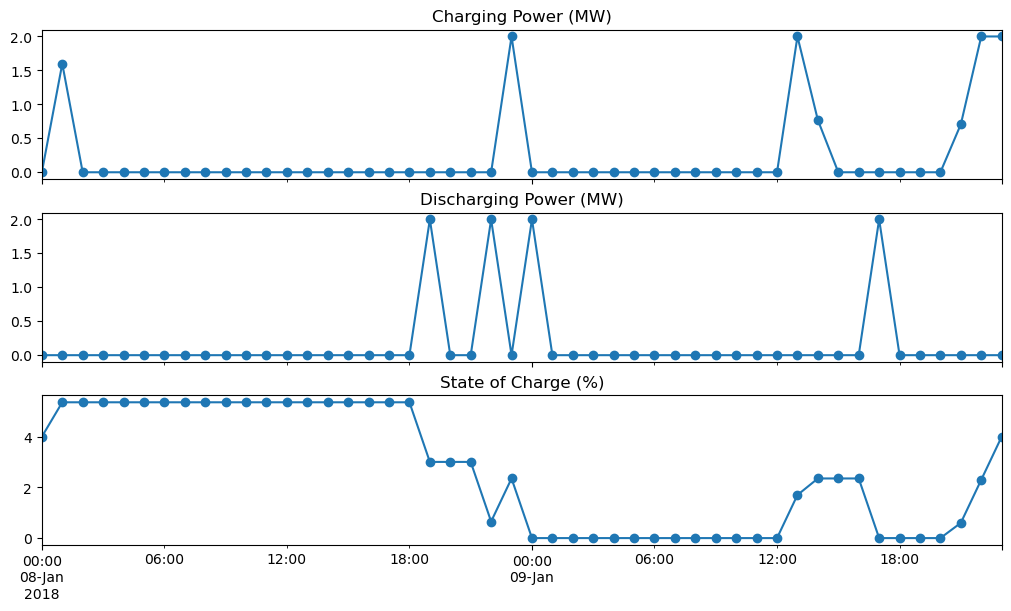

In [122]:
fig, ax = plt.subplots(3, 1, figsize=(10, 6),
                       sharex=True, layout='constrained')

results_0_w_esr['esrPCrg'].iloc[:, ii].plot(title='Charging Power (MW)', 
                                            ax=ax[0], marker='o')
results_0_w_esr['esrPDis'].iloc[:, ii].plot(title='Discharging Power (MW)', 
                                            ax=ax[1], marker='o')
results_0_w_esr['esrSOC'].iloc[:, ii].plot(title='State of Charge (%)', 
                                           ax=ax[2], marker='o')


In [123]:
print(
    f'Total cost: {results_0_wo_esr["total_cost"].sum():.2f}, {results_0_w_esr["total_cost"].sum():.2f}')
print(
    f'Gen cost: {results_0_wo_esr["gen_cost"].sum():.2f}, {results_0_w_esr["gen_cost"].sum():.2f}')
print(
    f'Over generation penalty: {results_0_wo_esr["over_gen_penalty"].sum():.2f}, {results_0_w_esr["over_gen_penalty"].sum():.2f}')
print(
    f'Load shed penalty: {results_0_wo_esr["load_shed_penalty"].sum():.2f}, {results_0_w_esr["load_shed_penalty"].sum():.2f}')
print(
    f'Ramp up penalty: {results_0_wo_esr["ramp_up_penalty"].sum():.2f}, {results_0_w_esr["ramp_up_penalty"].sum():.2f}')
print(
    f'Ramp down penalty: {results_0_wo_esr["ramp_down_penalty"].sum():.2f}, {results_0_w_esr["ramp_down_penalty"].sum():.2f}')
print(
    f'Interface max penalty: {results_0_wo_esr["if_max_penalty"].sum():.2f}, {results_0_w_esr["if_max_penalty"].sum():.2f}')
print(
    f'Interface min penalty: {results_0_wo_esr["if_min_penalty"].sum():.2f}, {results_0_w_esr["if_min_penalty"].sum():.2f}')
print(
    f'Branch max penalty: {results_0_wo_esr["br_max_penalty"].sum():.2f}, {results_0_w_esr["br_max_penalty"].sum():.2f}')
print(
    f'Branch min penalty: {results_0_wo_esr["br_min_penalty"].sum():.2f}, {results_0_w_esr["br_min_penalty"].sum():.2f}')

Total cost: 611294431.40, 535652560.12
Gen cost: 154501689.63, 154360099.59
Over generation penalty: 0.00, 0.00
Load shed penalty: 125494538.92, 72599061.79
Ramp up penalty: 0.00, 0.00
Ramp down penalty: 0.00, 0.00
Interface max penalty: 322631835.60, 299819301.65
Interface min penalty: 8666367.24, 8874029.74
Branch max penalty: 0.00, 0.00
Branch min penalty: 0.00, 0.00


In [124]:
# Create a dict where key is busIdx and value is zoneID
bus_zone_alloc = nygrid_sim_w_esr.grid_data['bus_prop'].set_index(
    'BUS_I').to_dict()['BUS_ZONE']
bus_names = list(bus_zone_alloc.keys())
bus_names_str = [f'Bus{i}' for i in bus_names]

In [125]:
lmp_wo_esr = results_0_wo_esr['LMP']
lmp_wo_esr.columns = bus_names

lmp_w_esr = results_0_w_esr['LMP']
lmp_w_esr.columns = bus_names

# Aggregate LMPs by zone
lmp_wo_esr_zone = lmp_wo_esr.groupby(bus_zone_alloc, axis=1).mean()
lmp_w_esr_zone = lmp_w_esr.groupby(bus_zone_alloc, axis=1).mean()

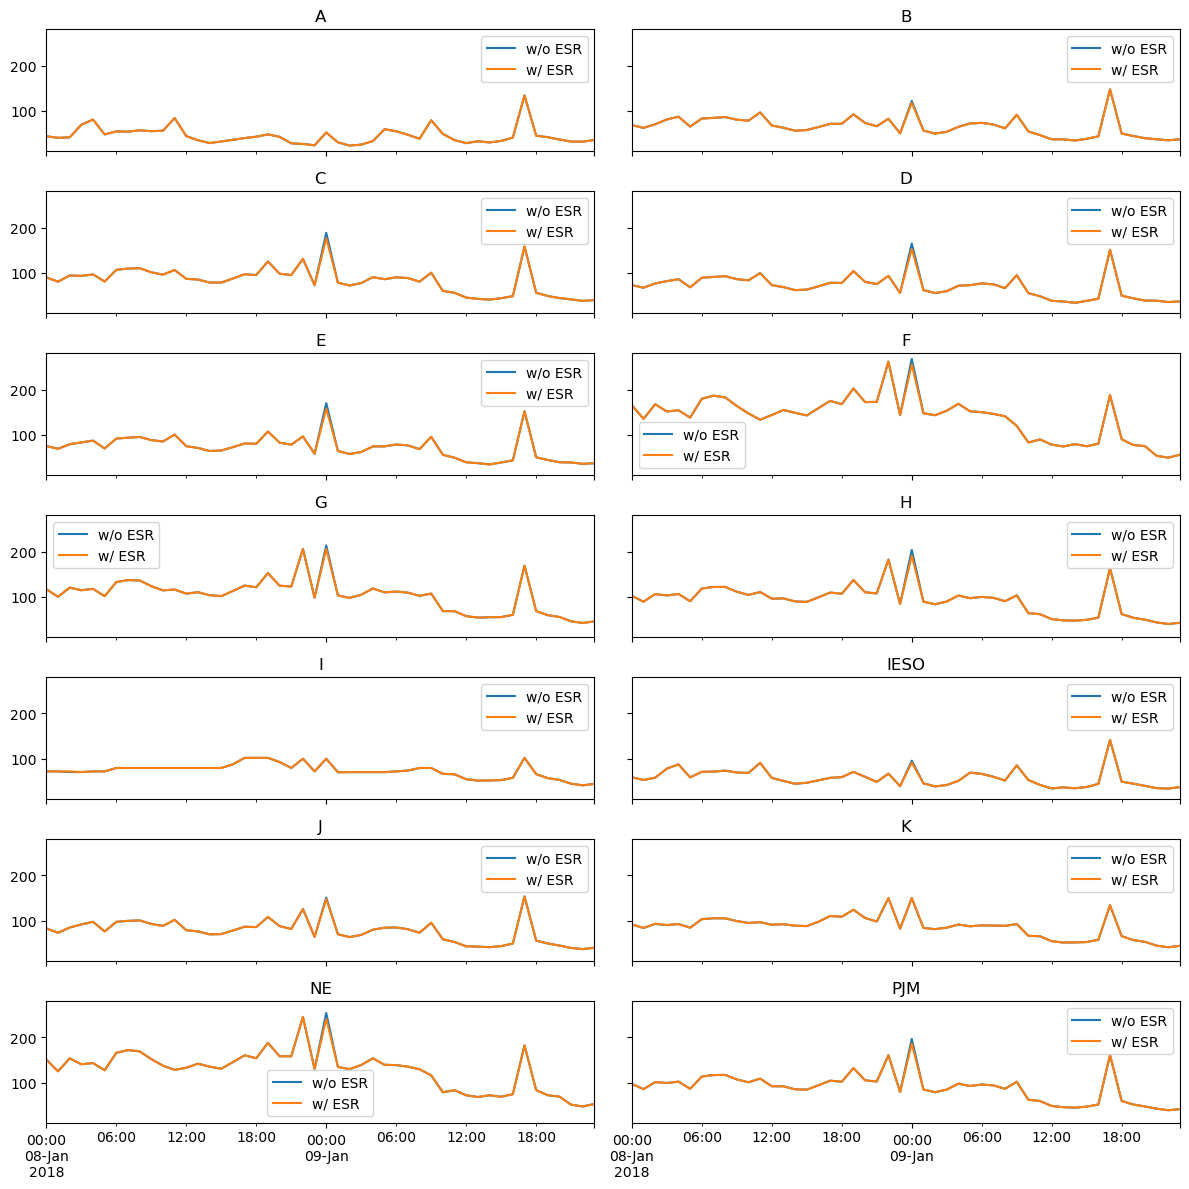

In [126]:
fig, axs = plt.subplots(7, 2, figsize=(12, 12), sharex='all', sharey='all')
# Plot LMPs w/o ESR
for i, ax in enumerate(axs.flat):
    lmp_wo_esr_zone.iloc[:, i].plot(ax=ax, label='w/o ESR')
    lmp_w_esr_zone.iloc[:, i].plot(ax=ax, label='w/ ESR')
    ax.set_title(lmp_w_esr_zone.columns[i])
    ax.legend()

fig.tight_layout()

<Axes: title={'center': 'Zonal Load'}, xlabel='TimeStamp'>

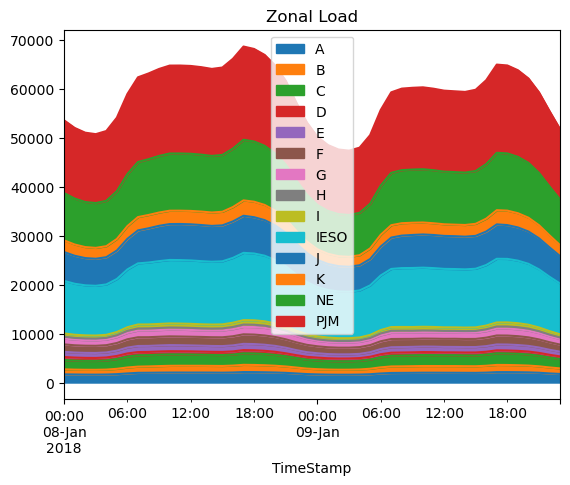

In [127]:
load_profile.columns = bus_names
load_profile_zone = load_profile.groupby(bus_zone_alloc, axis=1).sum()
load_profile_zone[start_datetime:end_datetime].plot.area(title="Zonal Load")

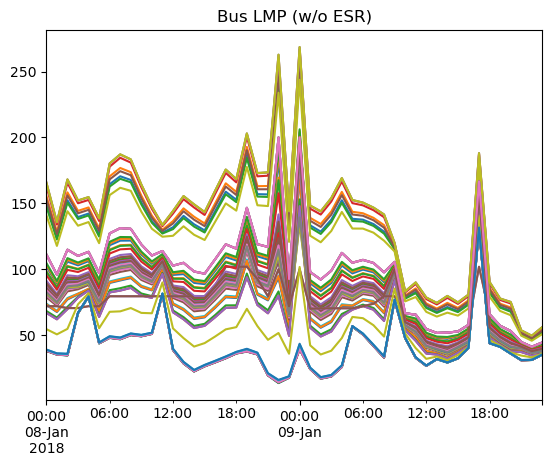

In [128]:
results_0_wo_esr['LMP'].plot(legend=False, title="Bus LMP (w/o ESR)")
plt.show()

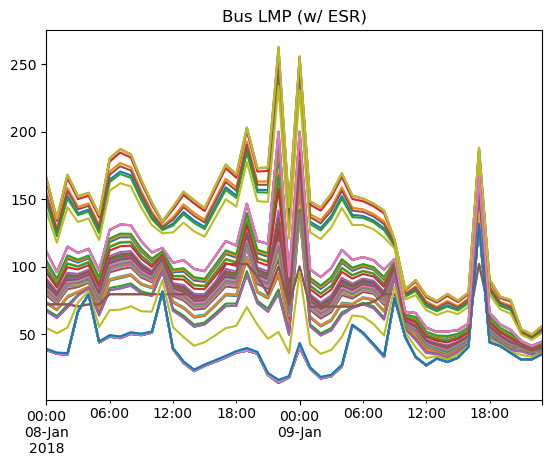

In [129]:
results_0_w_esr['LMP'].plot(legend=False, title="Bus LMP (w/ ESR)")
plt.show()

<Axes: title={'center': 'Bus LMP Difference (w/ ESR - w/o ESR)'}>

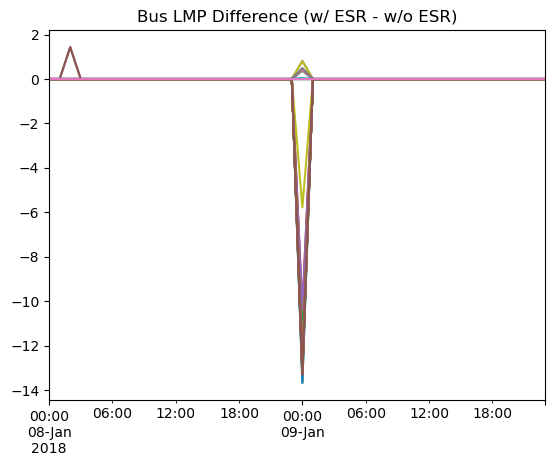

In [130]:
(results_0_w_esr['LMP'] - results_0_wo_esr['LMP']).plot(legend=False, title="Bus LMP Difference (w/ ESR - w/o ESR)")

### With initial conditions

In [131]:
# Only run for one day
d = d+1
start_datetime = timestamp_list[d]
end_datetime = start_datetime + timedelta(hours=47)
print(f'Start time: {start_datetime}')
print(f'End time: {end_datetime}')

Start time: 2018-01-09 00:00:00
End time: 2018-01-10 23:00:00


#### Without ESR

In [132]:
# Create NYGrid object
nygrid_sim_1_wo_esr = NYGrid(grid_data_dir,
                             start_datetime=start_datetime,
                             end_datetime=end_datetime,
                             dcline_prop=dcline_prop,
                             esr_prop=None,
                             vre_prop=None,
                             verbose=True)

# Set load and generation time series data
nygrid_sim_1_wo_esr.set_load_sch(load_profile)
nygrid_sim_1_wo_esr.set_gen_mw_sch(gen_profile)
nygrid_sim_1_wo_esr.set_gen_max_sch(genmax_profile)
nygrid_sim_1_wo_esr.set_gen_min_sch(genmin_profile)
nygrid_sim_1_wo_esr.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_1_wo_esr.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_1_wo_esr.relax_external_branch_lim()

# Set generator initial condition
last_gen = results_0_wo_esr['PG'].loc[start_datetime].to_numpy().squeeze()
nygrid_sim_1_wo_esr.set_gen_init_data(gen_init=last_gen)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    # 'PenaltyForBranchMwViolation': 10_000,
    # 'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_1_wo_esr.set_options(options)

# Solve DC OPF
nygrid_sim_1_wo_esr.solve_dc_opf()

# Get results
results_1_wo_esr = nygrid_sim_1_wo_esr.get_results_dc_opf()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-13
skipping further warning of this kind
Read LP format model from file /tmp/tmp5qbbjcrs.pyomo.lp
Reading time = 0.27 seconds
x1: 80016 rows, 64945 columns, 402338 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads
Optimize a model with 80016 rows, 64945 columns and 402338 nonzeros
Model fingerprint: 0xa03e4985
Coefficient statistics:
  Matrix range     [3e-06, 1e+00]
  Objective range  [3e+00, 2e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-17, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 74141 rows and 49872 columns
Presolve time: 0.12s
Presolved: 5875 rows, 15073 columns, 58848 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.322e+04
 Factor NZ  : 2.459e+05 (rou

In [133]:
print("s_ramp_up", results_1_wo_esr['s_ramp_up'].sum())
print("s_ramp_down", results_1_wo_esr['s_ramp_down'].sum())
print("s_over_gen", results_1_wo_esr['s_over_gen'].sum())
print("s_load_shed", results_1_wo_esr['s_load_shed'].sum())
print("s_if_max", results_1_wo_esr['s_if_max'].sum())
print("s_if_min", results_1_wo_esr['s_if_min'].sum())
print("s_br_max", results_1_wo_esr['s_br_max'].sum())
print("s_br_min", results_1_wo_esr['s_br_min'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 3380.7902523886946
s_if_max 10534.843746319311
s_if_min 594.591242063951
s_br_max 0.0
s_br_min 0.0


#### With ESR

In [134]:
# Create NYGrid object
nygrid_sim_1_w_esr = NYGrid(grid_data_dir,
                            start_datetime=start_datetime,
                            end_datetime=end_datetime,
                            dcline_prop=dcline_prop,
                            esr_prop=esr_prop,
                            vre_prop=None,
                            verbose=True)

# Set load and generation time series data
nygrid_sim_1_w_esr.set_load_sch(load_profile)
nygrid_sim_1_w_esr.set_gen_mw_sch(gen_profile)
nygrid_sim_1_w_esr.set_gen_max_sch(genmax_profile)
nygrid_sim_1_w_esr.set_gen_min_sch(genmin_profile)
nygrid_sim_1_w_esr.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_1_w_esr.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_1_w_esr.relax_external_branch_lim()

# Set generator initial condition
last_gen = results_0_w_esr['PG'].loc[start_datetime].to_numpy().squeeze()
nygrid_sim_1_w_esr.set_gen_init_data(gen_init=last_gen)

# Set storage initial SOC condition
last_soc = results_0_w_esr['esrSOC'].loc[start_datetime].to_numpy().squeeze()
nygrid_sim_1_w_esr.set_esr_init_data(esr_init=last_soc)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    # 'PenaltyForBranchMwViolation': 10_000,
    # 'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_1_w_esr.set_options(options)

# Solve DC OPF
nygrid_sim_1_w_esr.solve_dc_opf()

# Get results
results_1_w_esr = nygrid_sim_1_w_esr.get_results_dc_opf()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-13
skipping further warning of this kind
Read LP format model from file /tmp/tmpidsk6y9j.pyomo.lp
Reading time = 0.27 seconds
x1: 83864 rows, 69553 columns, 411938 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads
Optimize a model with 83864 rows, 69553 columns and 411938 nonzeros
Model fingerprint: 0x9f3ab656
Coefficient statistics:
  Matrix range     [3e-06, 2e+00]
  Objective range  [5e-01, 2e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-17, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 76024 rows and 51739 columns
Presolve time: 0.13s
Presolved: 7840 rows, 17814 columns, 64122 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.546e+04
 Factor NZ  : 2.313e+05 (rou

In [135]:
print("s_ramp_up", results_1_w_esr['s_ramp_up'].sum())
print("s_ramp_down", results_1_w_esr['s_ramp_down'].sum())
print("s_over_gen", results_1_w_esr['s_over_gen'].sum())
print("s_load_shed", results_1_w_esr['s_load_shed'].sum())
print("s_if_max", results_1_w_esr['s_if_max'].sum())
print("s_if_min", results_1_w_esr['s_if_min'].sum())
print("s_br_max", results_1_w_esr['s_br_max'].sum())
print("s_br_min", results_1_w_esr['s_br_min'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 3380.790252388695
s_if_max 10534.84374631931
s_if_min 594.5912420639513
s_br_max 0.0
s_br_min 0.0


## Process the results

In [136]:
# Read thermal generator info table
filename = os.path.join(grid_data_dir, 'genInfo.csv')
gen_info = pd.read_csv(filename)
num_thermal = gen_info.shape[0]
gen_rename = {gen_info.index[i]: gen_info.NYISOName[i]
              for i in range(num_thermal)}
gen_info

,NYISOName,PTID,Zone,UnitType,FuelType,Latitude,Longitude,maxPower,minPower,maxRampAgc,...,maxRamp60,HeatRateLM_1,HeatRateLM_0,HeatRateLM_R2,HeatRateQM_2,HeatRateQM_1,HeatRateQM_0,HeatRateQM_R2,useQM,start-time
0,59 St. GT 1,24138,J,Combustion Turbine,Kerosene,40.772385,-73.993028,17.1,0.0,1.710000,...,17.1,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
1,74 St. GT 1,24260,J,Combustion Turbine,Kerosene,40.768421,-73.951731,18.5,0.0,1.850000,...,18.5,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
2,74 St. GT 2,24261,J,Combustion Turbine,Kerosene,40.768421,-73.951731,18.5,0.0,1.850000,...,18.5,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
3,Allegany,23514,B,Combined Cycle,Natural Gas,42.508300,-78.066100,66.0,11.0,6.600000,...,66.0,8.218122,-14.577671,0.862443,-0.094773,15.209040,-125.857658,0.891407,1,10m
4,Allied Frozen Storage,23774,A,Internal Combustion,Natural Gas,42.842029,-78.722673,0.1,0.0,0.010000,...,0.1,8.899000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,Vernon Blvd 3,24163,J,Combustion Turbine,Natural Gas,40.753900,-73.950600,42.0,15.0,0.558333,...,33.5,17.272897,-319.572736,0.893510,0.524043,-14.979198,132.238854,0.935802,1,over
223,Wading River 1,23522,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,102.0,9.0,1.258333,...,75.5,12.779330,-5.232355,0.960069,-0.051615,18.026301,-96.225639,0.967170,1,over
224,Wading River 2,23547,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,94.0,7.8,1.350000,...,81.0,13.381103,-32.778267,0.981323,-0.027035,15.957351,-73.206752,0.982889,1,over
225,Wading River 3,23601,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,94.0,4.0,1.333333,...,80.0,12.154083,-11.601042,0.822005,-0.022269,14.190789,-39.250293,0.821057,1,over


In [137]:
# Format results
thermal_pg_0_wo_esr = (results_0_wo_esr['PG'].iloc[:, :num_thermal]
                       .rename(columns=gen_rename))

thermal_pg_0_w_esr = (results_0_w_esr['PG'].iloc[:, :num_thermal]
                      .rename(columns=gen_rename))

thermal_pg_1_wo_esr = (results_1_wo_esr['PG'].iloc[:, :num_thermal]
                       .rename(columns=gen_rename))

thermal_pg_1_w_esr = (results_1_w_esr['PG'].iloc[:, :num_thermal]
                      .rename(columns=gen_rename))

NYISOName              Allegany
PTID                      23514
Zone                          B
UnitType         Combined Cycle
FuelType            Natural Gas
Latitude                42.5083
Longitude              -78.0661
maxPower                   66.0
minPower                   11.0
maxRampAgc                  6.6
maxRamp10                  66.0
maxRamp30                  66.0
maxRamp60                  66.0
HeatRateLM_1           8.218122
HeatRateLM_0         -14.577671
HeatRateLM_R2          0.862443
HeatRateQM_2          -0.094773
HeatRateQM_1           15.20904
HeatRateQM_0        -125.857658
HeatRateQM_R2          0.891407
useQM                         1
start-time                  10m
Name: 3, dtype: object

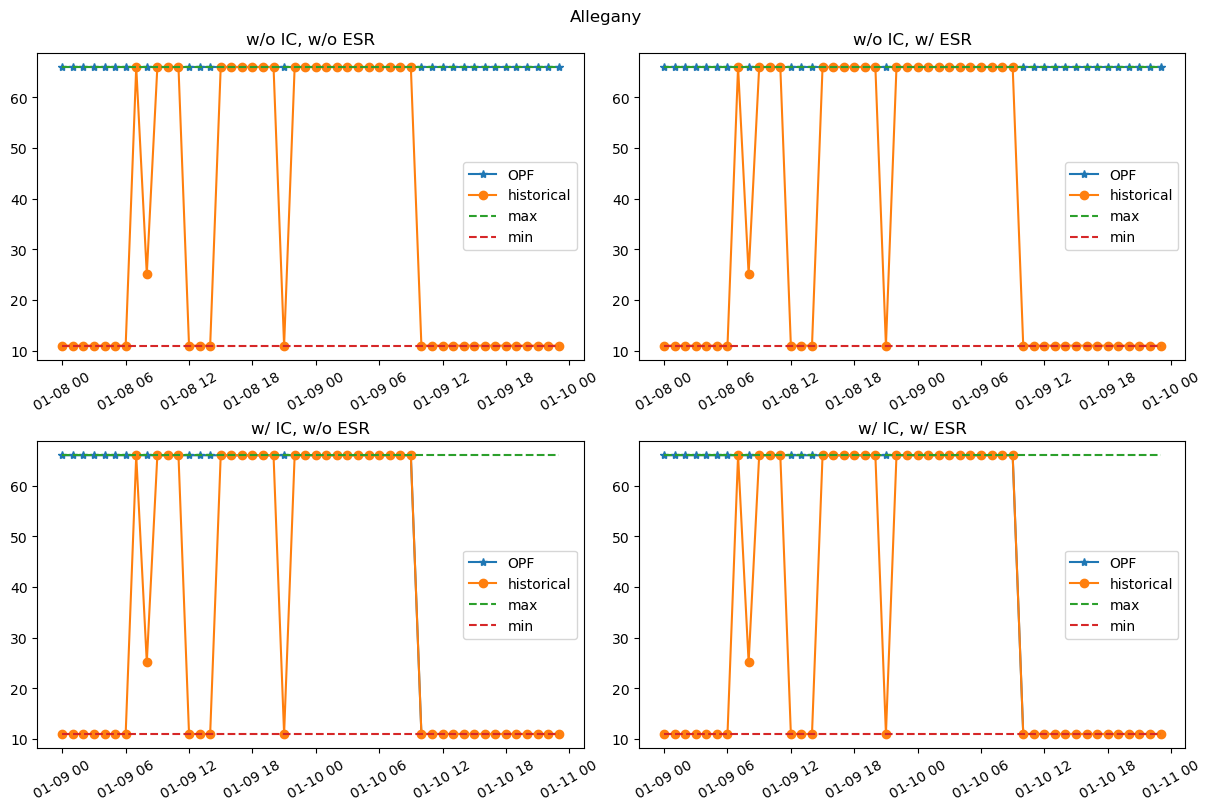

In [138]:
ii = 3
display(gen_info.iloc[ii, :])

fig, axs = plt.subplots(2, 2, figsize=(12, 8), layout='constrained')

axs[0, 0] = plot_gen(thermal_pg_0_wo_esr.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[0, 0], title="w/o IC, w/o ESR")
axs[0, 1] = plot_gen(thermal_pg_0_w_esr.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[0, 1], title="w/o IC, w/ ESR")
axs[1, 0] = plot_gen(thermal_pg_1_wo_esr.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[1, 0], title="w/ IC, w/o ESR")
axs[1, 1] = plot_gen(thermal_pg_1_w_esr.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[1, 1], title="w/ IC, w/ ESR")
for ax in axs.flat:
    ax.tick_params(axis='x', rotation=30)
fig.suptitle(f'{gen_info.NYISOName[ii]}')
fig.show()

NYISOName            Astoria 2
PTID                     24149
Zone                         J
UnitType         Steam Turbine
FuelType           Natural Gas
Latitude               40.7869
Longitude             -73.9122
maxPower                 153.0
minPower                   1.0
maxRampAgc                15.3
maxRamp10                153.0
maxRamp30                153.0
maxRamp60                153.0
HeatRateLM_1         10.720159
HeatRateLM_0        147.545513
HeatRateLM_R2         0.987563
HeatRateQM_2          0.007555
HeatRateQM_1          9.621049
HeatRateQM_0        170.560114
HeatRateQM_R2          0.98891
useQM                        1
start-time                 10m
Name: 9, dtype: object

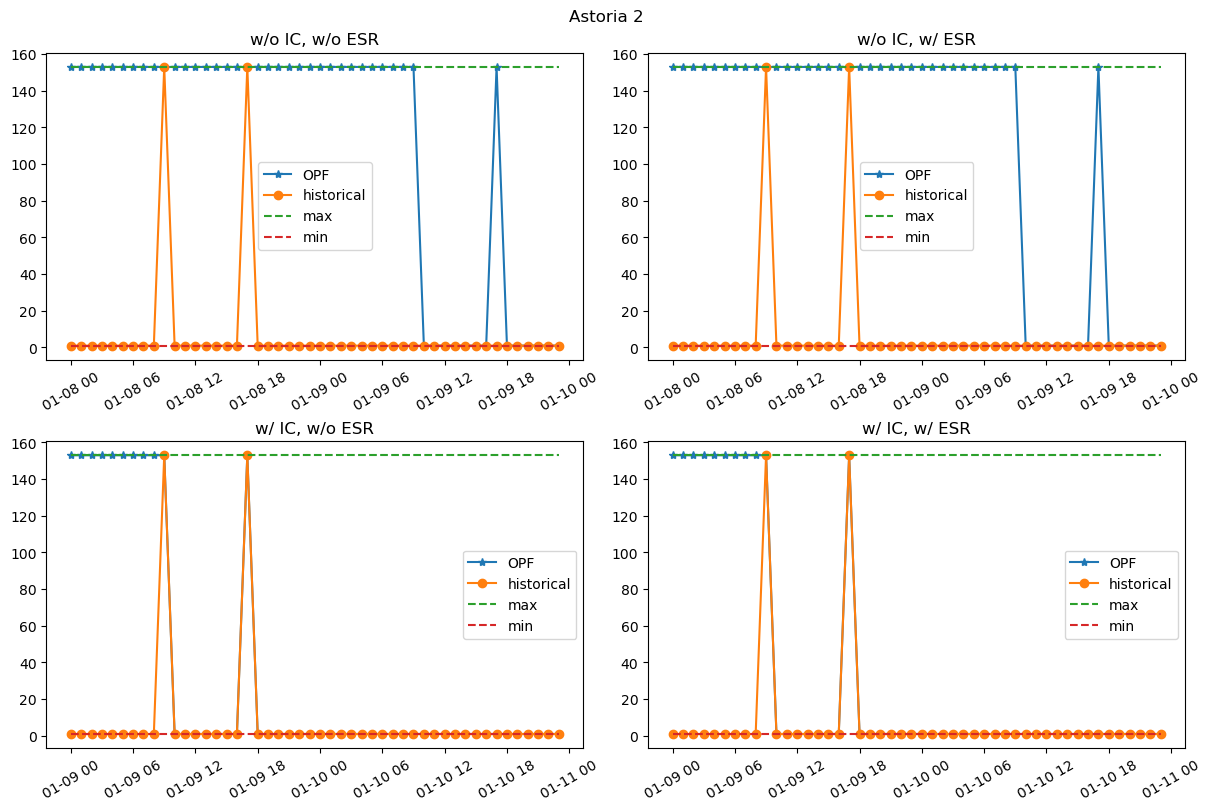

In [139]:
ii = 9
display(gen_info.iloc[ii, :])

fig, axs = plt.subplots(2, 2, figsize=(12, 8), layout='constrained')

axs[0, 0] = plot_gen(thermal_pg_0_wo_esr.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[0, 0], title="w/o IC, w/o ESR")
axs[0, 1] = plot_gen(thermal_pg_0_w_esr.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[0, 1], title="w/o IC, w/ ESR")
axs[1, 0] = plot_gen(thermal_pg_1_wo_esr.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[1, 0], title="w/ IC, w/o ESR")
axs[1, 1] = plot_gen(thermal_pg_1_w_esr.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[1, 1], title="w/ IC, w/ ESR")
for ax in axs.flat:
    ax.tick_params(axis='x', rotation=30)

fig.suptitle(f'{gen_info.NYISOName[ii]}')
fig.show()

NYISOName          East River 2
PTID                     323559
Zone                          J
UnitType         Combined Cycle
FuelType            Natural Gas
Latitude                40.7281
Longitude              -73.9742
maxPower                  227.0
minPower                   83.0
maxRampAgc                2.325
maxRamp10                 23.25
maxRamp30                 69.75
maxRamp60                 139.5
HeatRateLM_1           7.653993
HeatRateLM_0         446.985488
HeatRateLM_R2           0.98562
HeatRateQM_2           0.006054
HeatRateQM_1           5.870358
HeatRateQM_0          567.52178
HeatRateQM_R2          0.986302
useQM                         1
start-time                  12h
Name: 83, dtype: object

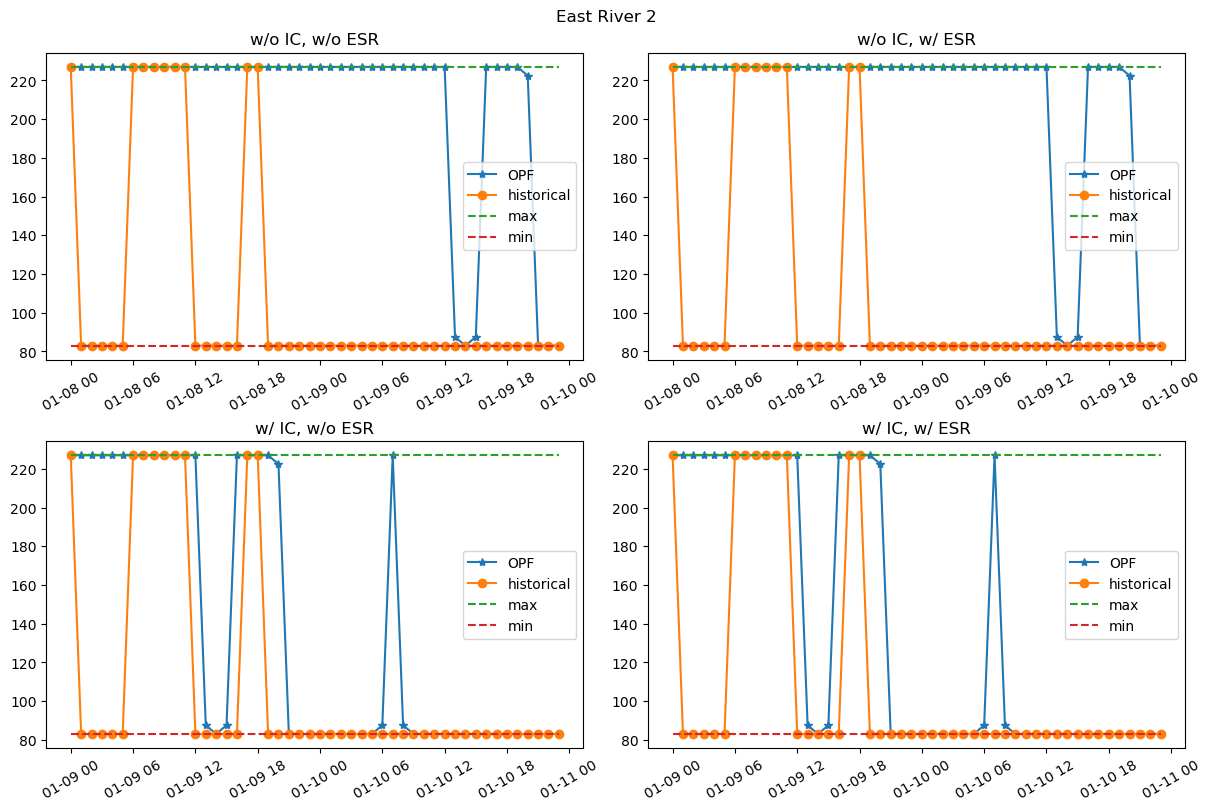

In [140]:
ii = 83
display(gen_info.iloc[ii, :])

fig, axs = plt.subplots(2, 2, figsize=(12, 8), layout='constrained')

axs[0, 0] = plot_gen(thermal_pg_0_wo_esr.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[0, 0], title="w/o IC, w/o ESR")
axs[0, 1] = plot_gen(thermal_pg_0_w_esr.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[0, 1], title="w/o IC, w/ ESR")
axs[1, 0] = plot_gen(thermal_pg_1_wo_esr.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[1, 0], title="w/ IC, w/o ESR")
axs[1, 1] = plot_gen(thermal_pg_1_w_esr.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[1, 1], title="w/ IC, w/ ESR")
for ax in axs.flat:
    ax.tick_params(axis='x', rotation=30)
fig.suptitle(f'{gen_info.NYISOName[ii]}')
fig.show()